<center> <h1>Using GraphWave </h1> </center>

&nbsp;

&nbsp;

The goal of the  following notebook is to show how the GraphWave algorithm can be used. 

GraphWave was implemented in Python 2.7 and requires to load the following Python packages:

+ __pygsp__ (Graph signal Processing package from EPFL, to compute spectral graph wavelets.)
+ __networkx__ (for handling network objects: in particular, visualization, etc.)
+ traditional libraries for data analytics: __seaborn__ for plotting, __pandas__ for dataframes


In [1]:
%matplotlib inline
import networkx as nx 
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from graphwave.shapes import build_graph
from graphwave.graphwave import *


np.random.seed(123)


## I. Creating a graph

In [2]:
%matplotlib inline
res=np.array([[100, 1.007087],[ 0.699462, 3.042903],
[500, 8.482315],
[1000, 19.191575],
[5000, 283.553013],
[10000, 2942.717718],
[15000, 8623.728076]])

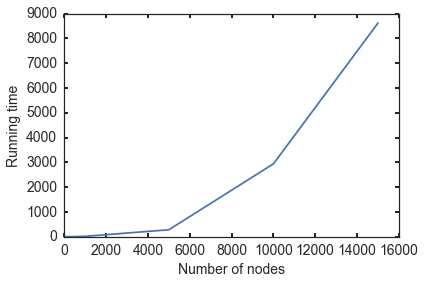

In [22]:
fig, ax = plt.subplots()
sb.set_style('white')
plt.plot(res[:,0], res[:,1])
plt.xlabel('Number of nodes',fontsize = 14)
plt.ylabel('Running time',fontsize = 14)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
ax.tick_params(direction='in', length=4, width=2)
plt.savefig("computational_complexity.pdf", bbox_inches='tight')

                # specify integer or one of p

In [21]:
help(plt.savefig)

Help on function savefig in module matplotlib.pyplot:

savefig(*args, **kwargs)
    Save the current figure.
    
    Call signature::
    
      savefig(fname, dpi=None, facecolor='w', edgecolor='w',
              orientation='portrait', papertype=None, format=None,
              transparent=False, bbox_inches=None, pad_inches=0.1,
              frameon=None)
    
    The output formats available depend on the backend being used.
    
    Arguments:
    
      *fname*:
        A string containing a path to a filename, or a Python
        file-like object, or possibly some backend-dependent object
        such as :class:`~matplotlib.backends.backend_pdf.PdfPages`.
    
        If *format* is *None* and *fname* is a string, the output
        format is deduced from the extension of the filename. If
        the filename has no extension, the value of the rc parameter
        ``savefig.format`` is used.
    
        If *fname* is not a string, remember to specify *format* to
        ensur

In [13]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 23 10:32:21 2018

@author: cdonnat
"""

import networkx as nx
import numpy as np
import scipy as sc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from graphwave.shapes import build_graph
#from graphwave.graphwave import *
import time
np.random.seed(123)
import copy
import math

def compute_cheb_coeff(scale, order):
    coeffs = [(-scale)**k * 1.0 / math.factorial(k) for k in range(order + 1)]
    return coeffs

def compute_cheb_coeff_basis(scale, order):
    xx = np.array([np.cos((2*i-1)*1.0/(2*order) * math.pi) for i in range(1,order+1)])
    basis = [np.ones((1,order)),np.array(xx)]
    for k in range(order + 1-2):
        basis.append(2* np.multiply(xx, basis[-1]) - basis[-2])
    basis = np.vstack(basis)
    f = np.exp(-scale*(xx+1))
    products = np.einsum("j,ij->ij",f,basis)
    coeffs = 2.0/(order)*products.sum(1)
    coeffs[0] = coeffs[0]/2
    return list(coeffs)




def heat_diffusion_ind(graph, taus=[1, 10, 25, 50], diff_type='heat',order = 10, proc = 'approximate'):
    '''
    This method computes the heat diffusion waves for each of the nodes
    INPUT:
    -----------------------
    graph    :    Graph, can be of type networkx or pygsp
    taus     :    list of 4 scales for the wavelets. The higher the tau,
                  the better the spread
    order    :    order of the polynomial approximation

    OUTPUT:
    -----------------------
    heat     :     tensor of length  len(tau) x n_nodes x n_nodes
                   where heat[tau,:,u] is the wavelet for node u
                   at scale tau
    '''
    # Compute Laplacian

    a = nx.adjacency_matrix(graph)
    n_nodes, _ = a.shape
    thres = np.vectorize(lambda x : x if x > 1e-4*1.0/n_nodes else 0)
    lap = laplacian(a)
    n_filters = len(taus)
    if proc == 'exact':
        lamb, U = np.linalg.eigh(lap.todense())
        heat = {}
        for i in range(n_filters):
             heat[i] = U.dot(np.diagflat(np.exp(-taus[i]*lamb).flatten())).dot(U.T)
    else:
        heat = {i: sc.sparse.csc_matrix((n_nodes, n_nodes)) for i in range(n_filters) }
        #monome = {0: sc.sparse.eye(n_nodes)}
        #for k in range(1, order + 1):
        #     monome[k] = lap.dot(monome[k-1])
        monome = {0: sc.sparse.eye(n_nodes), 1: lap - sc.sparse.eye(n_nodes)}
        for k in range(2, order + 1):
             monome[k] = 2 * (lap - sc.sparse.eye(n_nodes)).dot(monome[k-1]) - monome[k - 2]
        for i in range(n_filters):
            coeffs = compute_cheb_coeff_basis(taus[i], order)
            #print(coeffs)
            heat[i] = sc.sum([  coeffs[k] * monome[k]  for k in range(0, order + 1)])
            index = heat[i].nonzero
            #temp = heat[i].A#
            temp = thres(heat[i].A)
            heat[i] = sc.sparse.csc_matrix(temp)
            #### trim the data:

             #for k in range(0, order + 1):
                 #heat[i] +=  coeffs[k] * monome[k]
    return heat, taus



import copy

def charac_function(time_points, temp):
#time_points= np.linspace(0,100,101)
#if True
    

    complexify = np.vectorize( lambda x: np.exp(-np.complex(0,x)))
    n_nodes = temp.shape[1]
    sig = np.zeros((len(time_points), n_nodes), dtype='complex128')
    nnz_vec = np.array([1.0/n_nodes*(temp[:,i].nnz) for i in range(n_nodes)])
    temp2 = copy.deepcopy(temp)
    for it_t, t in enumerate(time_points):
        temp2.data = complexify(t*temp.data)
        sig[it_t,:] = 1.0/n_nodes *(temp2.sum(0)) + nnz_vec
    
    final_sig = np.zeros((2*sig.shape[0],sig.shape[1]))
    final_sig[::2,:] = np.real(sig)
    final_sig[1::2,:]= np.imag(sig)
    return final_sig

def charac_function_multiscale(heat, time_points):
    final_sig = []
    for i in heat.keys():
        final_sig.append(charac_function(time_points, heat[i]))
    return np.vstack(final_sig).T


def laplacian(a):
        n_nodes, _ = a.shape
        posinv = np.vectorize(lambda x: 1.0/np.sqrt(x) if x>1e-10 else 1)
        d = sc.sparse.diags(np.array(posinv(a.sum(0))).reshape([-1,]),0)
        lap = sc.sparse.eye(n_nodes) - d.dot(a.dot(d))
        return lap

def graphwave2(graph, taus, time_pnts, type_graph="nx",
              verbose=False, **kwargs):
    ''' wrapper function for computing the structural signatures using GraphWave
    INPUT
    --------------------------------------------------------------------------------------
    graph      :   nx or pygsp Graph
    time_pt    :   time points at which to evaluate the characteristic function
    taus       :   list of scales that we are interested in. Alternatively,
                   'automatic' for the automatic version of GraphWave
    type_graph :   type of the graph used (either one of 'nx' or 'pygsp')
    verbose    :   the algorithm prints some of the hidden parameters
                   as it goes along
    OUTPUT
    --------------------------------------------------------------------------------------
    chi        :  embedding of the function in Euclidean space
    heat_print :  returns the actual embeddings of the nodes
    taus       :  returns the list of scales used.
    '''
    if taus == 'auto':
        a = nx.adjacency_matrix(G)
        lap = laplacian(a)
        try:
            l1 = np.sort(sc.sparse.linalg.eigsh(lap, 2,  which='SM',return_eigenvectors=False))[1]
        except:
            l1 = np.sort(sc.sparse.linalg.eigsh(lap, 5,  which='SM',return_eigenvectors=False))[1]
        smax = -np.log(0.8) * np.sqrt( 0.5 / l1)
        smin = -np.log(0.95) * np.sqrt( 0.5 / l1)
        taus = np.linspace(smin, smax, 2)
    heat_print, _ = heat_diffusion_ind(graph, list(taus), diff_type='heat', order=50, proc = 'approximate')
    chi = charac_function_multiscale(heat_print, time_pnts)

    return chi, heat_print, taus

time_alg=[]
if True:
    
    nbTrials = 20


    ################################### EXAMPLE TO BUILD A SIMPLE REGULAR STRUCTURE ##########
    ## REGULAR STRUCTURE: the most simple structure:  basis + n small patterns of a single type

    ### 1. Choose the basis (cycle, torus or chain)
    basis_type = "cycle"

    ### 2. Add the shapes
    n_shapes = 100 ## numbers of shapes to add
    width_basis = 5 * n_shapes
    #shape=["fan",6] ## shapes and their associated required parameters  (nb of edges for the star, etc)
    #shape=["star",6]
    list_shapes = [["house"]] * n_shapes

    ### 3. Give a name to the graph
    identifier = 'AA'  ## just a name to distinguish between different trials
    name_graph = 'houses'+ identifier


    ### 4. Pass all these parameters to the Graph Structure
    add_edges = 0
    G, communities, _ , role_id = build_graph.build_structure(width_basis, basis_type, list_shapes, start=0,
                                           add_random_edges=add_edges, plot=False,
                                           savefig=False)
    tic =time.time()
    time_pts = list(np.arange(0,20,1)) 
    chi, heat, taus = graphwave2(G, 'auto', time_pts)
    toc =time.time()
    time_alg+=[[G.number_of_nodes(),toc-tic]]
    np.savetxt('log_scalable.txt', time_alg, fmt="%i, %f")
    print toc-tic






14.4434549809


In [25]:
# 1- Start by defining our favorite regular structure

filename_graph_indic="/Users/cdonnat/Downloads/Wiki-Vote.txt"
edge_list=[]
with open(filename_graph_indic) as f:
    i = 0
    for line in f:
        line=line.strip("\n")
        line=line.strip("\r")
        if i > 5:
            line = line.split('\t')
            edge_list += [[int(line[0]),int(line[1])]]
        i += 1

In [26]:
graph = nx.from_edgelist(edge_list)

In [1]:
time =[(90, 2.272922992706299),
(315, 26.121266841888428),
(540, 91.55953407287598),
(765, 194.64284420013428),
(990, 292.62941098213196),
(1215, 473.310791015625),
(1440, 580.7945530414581),
(1665, 831.6506588459015),
(1890, 1013.45339179039),
(2115, 1132.4784269332886),
(2340, 1394.946408033371),
(2565, 1679.3355889320374),
(2790, 1979.6715250015259),
(3015, 2308.3219091892242),
(3240, 2671.358288049698),
(3465, 3048.7422091960907),
(3690, 3478.4642791748047),
(3915, 3893.762937068939)] 

In [9]:
3893/60

64

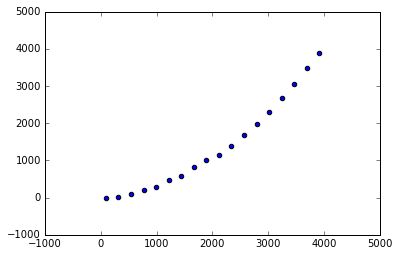

In [7]:
%matplotlib inline
import numpy as np
time =np.array(time)
import matplotlib.pyplot as plt
plt.scatter(time[:,0], time[:,1])

In [6]:
nx.number_connected_components(graph)

24

In [7]:
conn_comp={}
it_g = 0
for g in nx.connected_component_subgraphs(graph):
    conn_comp[it_g] = g
    print(it_g, g.number_of_nodes())
    it_g += 1

(0, 7066)
(1, 2)
(2, 2)
(3, 2)
(4, 2)
(5, 2)
(6, 2)
(7, 2)
(8, 2)
(9, 2)
(10, 2)
(11, 2)
(12, 2)
(13, 2)
(14, 2)
(15, 3)
(16, 2)
(17, 2)
(18, 3)
(19, 2)
(20, 2)
(21, 2)
(22, 2)
(23, 3)


In [8]:
taus = list(np.arange(0.5, 3.0, 0.2))+list(range(3, 5))
# Compute the optimal embedding
pygsp_graph = pygsp.graphs.Graph(nx.adjacency_matrix(conn_comp[0]),
                                 lap_type='normalized')

In [9]:
pygsp_graph.L

<7066x7066 sparse matrix of type '<type 'numpy.float64'>'
	with 208534 stored elements in Compressed Sparse Row format>

In [10]:
pygsp_graph.connected


True

In [21]:
#pygsp_graph.compute_fourier_basis(recompute=True)
# safety check to ensure that the graph is indeed connected
l1 = sc.sparse.linalg.eigsh(pygsp_graph.L, k=2, which='SM')[0][1]
smax = -np.log(0.75) * np.sqrt(2.0 / l1)
smin = -np.log(0.90) * np.sqrt(2.0/ l1)
taus = list(np.linspace(smin,smax,10))

In [ ]:
import time
tic=time.time()
diff_type = 'heat'
n_nodes = pygsp_graph.N
if True:
    n_filters = len(taus)

    if diff_type == 'mexican':
        n_filters = 6
        Hk = pygsp.filters.MexicanHat(pygsp_graph, n_filters)
    elif diff_type == 'wave':
        Hk = pygsp.filters.Wave(pygsp_graph, taus, normalize=True)
    else:
        Hk = pygsp.filters.Heat(pygsp_graph, taus, normalize=False)

heat = {tau: sc.sparse.csc_matrix(( n_nodes, n_nodes)) for tau in taus}
Sf_vec = Hk.analysis(np.eye(n_nodes), cheb_order = 10)
toc =time.time()
print(toc-tic)

In [14]:
#### Then we need to convert them into an adequate format

In [13]:
help(Hk)

Help on Heat in module pygsp.filters.heat object:

class Heat(pygsp.filters.filter.Filter)
 |  Heat Filterbank
 |  
 |  Inherits its methods from Filters
 |  
 |  Parameters
 |  ----------
 |  G : Graph
 |  tau : int or list of ints
 |      Scaling parameter. (default = 10)
 |  normalize : bool
 |      Normalize the kernel (works only if the eigenvalues are
 |      present in the graph). (default = 0)
 |  
 |  Returns
 |  -------
 |  out : Heat
 |  
 |  Examples
 |  --------
 |  >>> from pygsp import graphs, filters
 |  >>> G = graphs.Logo()
 |  >>> F = filters.Heat(G)
 |  
 |  Method resolution order:
 |      Heat
 |      pygsp.filters.filter.Filter
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, G, tau=10, normalize=False, **kwargs)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from pygsp.filters.filter.Filter:
 |  
 |  analysis(self, s, method=None, cheb_order=30, lanczos_order=30, **kwargs)
 |

In [15]:
for i in range(n_filters):
        heat[taus[i]]= sc.sparse.csc_matrix(Sf_vec[i * n_nodes: (i + 1) * n_nodes, :] )    # stores in tensor the results

In [20]:
np.sort(heat[taus[9]][:,0].todense())

matrix([[  7.83515091e-01],
        [  7.34737288e-05],
        [  5.90369948e-05],
        ..., 
        [  1.19696857e-07],
        [  7.96622698e-09],
        [  2.41718737e-08]])

In [17]:
7066 * 7066

49928356

(Note: best visualization of the graphs are obtained using Gephi, or some other specialized graph visualization software)

## II. Running GraphWave


We propose here a simple demonstration of GraphWave using both the automatic version (part a) and the manual version. This shows how to use GraphWave in a parameter-free version, or giving the analyst the possibility to select an adequate scale value.

For each of these approaches, we compute the signature by calling GraphWave. We then compute its PCA projection to visualize the embeddings. Note that in this very simple examples, GraphWave recovers structura equivalence, as shown by the overlapping embeddings on the first principal components.

#### a. Multiscale GraphWave: Automatic selection of the range of scales

In [ ]:
chi, heat_print, taus = graphwave(graph, taus='automatic_large_matrix', verbose=False)

We now visualize the resulting embeddings by computing their PCA projections. We also run KMeans to assess how well the signatures that we have here generated enable the recovery of structural roles.

In [ ]:
nb_clust = len(np.unique(role_id))
pca = PCA(n_components=5)
trans_data = pca.fit_transform(StandardScaler().fit_transform(chi))
km = KMeans(n_clusters=nb_clust)
km.fit(trans_data)
labels_pred=km.labels_

######## Params for plotting
cmapx=plt.get_cmap('rainbow')
x=np.linspace(0,1,nb_clust+1)
col=[cmapx(xx) for xx in x ]
markers = {0:'*',1: '.', 2:',',3: 'o',4: 'v',5: '^',6: '<',7: '>',8: 3 ,9:'d',10: '+',11:'x',12:'D',13: '|',14: '_',15:4,16:0,17:1,18:2,19:6,20:7}

for c in np.unique(role_id):
    indc = [i for i,x in enumerate(role_id) if x==c]
    plt.scatter(trans_data[indc,0], trans_data[indc,1],
                c=np.array(col)[list(np.array(labels_pred)[indc])],
                marker=markers[c%len(markers)], s=300)

labels = role_id
for label,c, x, y in zip(labels,labels_pred, trans_data[:, 0], trans_data[:, 1]):
            plt.annotate(label,xy=(x, y), xytext=(0, 0), textcoords='offset points')
            

#### Uniscale GraphWave: Hand-selected value for tau

In [ ]:
### Select a scale of interest (here we select a particular range of scale. See associated paper for 
### guidelines on how to select the appropriate scale.)

### Compute the heat wavelet
from graphwave.graphwave import *

time_pts = list(np.arange(0,50,0.5))
chi,heat_print, taus=graphwave(G, taus = [0.5], time_pts=time_pts, verbose=False)
print(chi.shape, len(time_pts))

Note that in the EPFL implementation, by construction, the wavelet scales are all divided by the maximum eigenvalue $\lambda_N$.

In [ ]:
nb_clust=len(np.unique(role_id))
pca=PCA(n_components=5)
trans_data=pca.fit_transform(StandardScaler().fit_transform(chi))
km=KMeans(n_clusters=nb_clust)
km.fit(trans_data)
labels_pred=km.labels_


cmapx=plt.get_cmap('rainbow')
x=np.linspace(0,1,np.max(labels_pred)+1)
col=[cmapx(xx) for xx in x ]
markers = {0:'*',1: '.', 2:',',3: 'o',4: 'v',5: '^',6: '<',7: '>',8: 3 ,9:'d',10: '+',11:'x',12:'D',13: '|',14: '_',15:4,16:0,17:1,18:2,19:6,20:7}


for c in np.unique(role_id):
        indc=[i for i,x in enumerate(role_id) if x==c]
        _ = plt.scatter(trans_data[indc,0], trans_data[indc,1],c=np.array(col)[list(np.array(labels_pred)[indc])] ,marker=markers[c%len(markers)],s=500)

labels = role_id
for label,c, x, y in zip(labels,labels_pred, trans_data[:, 0], trans_data[:, 1]):
            _ = plt.annotate(label,xy=(x, y), xytext=(0, 0), textcoords='offset points')
            

## III. Visualizing the Characteristic functions

We now propose to show how to visualize characteristic functions.


In [ ]:
mapping = {u: i for i,u in enumerate(np.unique(role_id))}
cmap=plt.get_cmap('gnuplot')
role_id_plot=[cmap(x) for x in np.linspace(0,1,len(np.unique(role_id)))]
plt.figure()
ind_x=range(chi[0].shape[0])[0::2]
ind_y=range(chi[0].shape[0])[1::2]
for i in np.random.choice(range(G.number_of_nodes()),10,replace=False):
    _ = plt.plot(chi[i,ind_x],chi[i,ind_y],label=str(i),color=role_id_plot[mapping[role_id[i]]])

_ = plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
